In [2]:
!pip install pymc

     |████████████████████████████████| 473 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 22.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.8 MB 17.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 12.0 MB/s eta 0:00:01
     |████████████████████████████████| 43 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 41 kB 232 kB/s eta 0:00:011
     |████████████████████████████████| 5.3 MB 13.7 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 3.4 MB/s  eta 0:00:01
  Created wheel for logical-unification: filename=logical_unification-0.4.6-py3-none-any.whl size=13912 sha256=951c991c610d93f20ce21ccbf5070d768b9a0c6c498b8eef0c337f465573ffde
  Stored in directory: /home/.cache/pip/wheels/c0/b5/eb/4af72f29fe7c242c96064dcc7f0c0925e879f02ef0a2858627
  Created wheel for cons: filename=cons-0.4.6-py3-none-any.whl size=9097 sha256=f4b895e2eea210c03c55eb1801c1403862053cc3d9b2605d02e94419f68d5a25
  Stored in directory: /h

# Load datasets

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import os
import calendar
from datetime import datetime, timedelta, date
import warnings
#import kaggle 
import zipfile
import pandas as pd
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kde
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.impute import SimpleImputer
import pymc as pm
import arviz as az
import warnings
pd.set_option('display.max_columns', None)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
database_path = "datasets/football/european-football/database.sqlite" 
conn = sqlite3.connect(database_path)
tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
print(tables)

    type               name           tbl_name  rootpage  \
0  table    sqlite_sequence    sqlite_sequence         4   
1  table  Player_Attributes  Player_Attributes        11   
2  table             Player             Player        14   
3  table              Match              Match        18   
4  table             League             League        24   
5  table            Country            Country        26   
6  table               Team               Team        29   
7  table    Team_Attributes    Team_Attributes         2   

                                                 sql  
0             CREATE TABLE sqlite_sequence(name,seq)  
1  CREATE TABLE "Player_Attributes" (\n\t`id`\tIN...  
2  CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...  
3  CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...  
4  CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...  
5  CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...  
6  CREATE TABLE "Team" (\n\t`id`\tINTEGER PRIMARY...  
7  CREATE TABLE `Te

In [5]:
dataframes = {}
for idx, name in enumerate(tables['name']):
    if name.lower() != "sqlite_sequence":
        file = ((name.lower() + '_df'))
        if file != "_df":
            query = f"\
                    SELECT * \
                    FROM {name}\
                    "
            df = pd.read_sql(query, conn)
            exec(f'{file} = df.copy()')
            print(file, df.shape)
            df = df.drop_duplicates()
            dataframes[file]= df
print("Data imported")

player_attributes_df (183978, 42)
player_df (11060, 7)
match_df (25979, 115)
league_df (11, 3)
country_df (11, 2)
team_df (299, 5)
team_attributes_df (1458, 25)
Data imported


In [6]:
# Set the directory path.
kaggle_dataset_path = 'davidcariboo/player-scores'
directory_path = 'datasets/football/player-scores'
# Download the datasets
#directory_path = os.path.expanduser('~/src/sorrentum1/research_llm/player-scores')
#os.makedirs(directory_path, exist_ok=True)
#kaggle.api.dataset_download_files(kaggle_dataset_path, path=directory_path, unzip=True)
# Manually unzip the files.
#for dirname, _, filenames in os.walk(local_directory):
#    for filename in filenames:
#        if filename.endswith('.zip'):
#            zip_path = os.path.join(dirname, filename)
#            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#                zip_ref.ref.extractall(local_directory)
# Load the datasets into pandas dataframes.            
dataframes_2={}
for dirname, _, filenames in os.walk(directory_path):
    for filename in filenames:
        if filename.endswith(".csv"):
            file=filename.split('.')
            file=((file[0]+"_df"))
            if file !="_df":
                filepath=os.path.join(dirname,filename)
                df=pd.read_csv(filepath,sep=",",encoding = "UTF-8")
                exec(f'{file} = df.copy()')
                print(file, df.shape)
                df = df.drop_duplicates()
                dataframes_2[file]= df
print('Data imported')

games_df (67964, 23)
appearances_df (1573079, 13)
competitions_df (43, 11)
clubs_df (426, 17)
players_df (30516, 23)
game_lineups_df (2191911, 10)
game_events_df (734047, 10)
player_valuations_df (467132, 5)
club_games_df (135928, 11)
Data imported


In [7]:
# Set the directory path.
kaggle_dataset_path2 = 'davidcariboo/player-scores'
directory_path = 'datasets/football/player_attributes'
# Download the datasets
#directory_path = os.path.expanduser('~/src/sorrentum1/research_llm/player-scores')
#os.makedirs(directory_path, exist_ok=True)
#kaggle.api.dataset_download_files(kaggle_dataset_path, path=directory_path, unzip=True)
# Manually unzip the files.
#for dirname, _, filenames in os.walk(local_directory):
#    for filename in filenames:
#        if filename.endswith('.zip'):
#            zip_path = os.path.join(dirname, filename)
#            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#                zip_ref.ref.extractall(local_directory)
# Load the datasets into pandas dataframes.            
dataframes_3={}
for dirname, _, filenames in os.walk(directory_path):
    for filename in filenames:
        if filename.endswith(".csv"):
            file=filename.split('.')
            file=((file[0]+"_df"))
            if file !="_df":
                filepath=os.path.join(dirname,filename)
                df=pd.read_csv(filepath,sep=";",encoding = "UTF-8")
                exec(f'{file} = df.copy()')
                print(file, df.shape)
                df = df.drop_duplicates()
                dataframes_3[file]= df
print('Data imported')

fifa13_df (15686, 48)
fifa07_df (10912, 37)
fifa06_df (10151, 37)
fifa20_df (20527, 48)
fifa17_df (15656, 48)
fifa05_df (10970, 37)
fifa12_df (14922, 48)
fifa19_df (19128, 48)
fifa11_df (15020, 48)
fifa08_df (12763, 37)
fifa18_df (19126, 48)
fifa14_df (17270, 48)
fifa10_df (14975, 37)
fifa21_df (19002, 48)
fifa09_df (14800, 37)
fifa15_df (17047, 48)
fifa16_df (13507, 48)
Data imported


## Create a master_player (for all player_attributes each season against year) and master_games to capture the details of individual games

In [8]:
# Iterate over the dictionary.
all_data = []
for key, df in dataframes_3.items():
    # Extract year from the key.
    df['year'] = int('20' + key[-5:-3])
    dataframes_3[key] = df
    all_data.append(df)
for i in range(3):
    df['year'] = 2022 + i
    all_data.append(df)
master_player = pd.concat(all_data, ignore_index=True)
# Drop the columns with NaN values.
master_player = master_player.dropna(axis=1)
# Create a master_games df.
master_games = games_df

Determine home win in `home_win`. When the value is `1`, home club won, value is `0` home club lost and `-1` in case of a draw  

In [9]:
# Create 'home_win' column
def determine_home_win(row):
    if row['home_club_goals'] > row['away_club_goals']:
        return 1
    elif row['home_club_goals'] < row['away_club_goals']:
        return 0
    else:
        return -1
    
master_games['home_win'] = master_games.apply(determine_home_win, axis=1)
master_games.head()

,game_id,competition_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,away_club_position,home_club_manager_name,away_club_manager_name,stadium,attendance,referee,url,home_club_formation,away_club_formation,home_club_name,away_club_name,aggregate,competition_type,home_win
0,2321044,L1,2013,2. Matchday,2013-08-18,16,23,2,1,1.0,15.0,Jürgen Klopp,Torsten Lieberknecht,SIGNAL IDUNA PARK,80200.0,Peter Sippel,https://www.transfermarkt.co.uk/borussia-dortm...,4-2-3-1,4-3-2-1,Borussia Dortmund,Eintracht Braunschweig,2:1,domestic_league,1
1,2321060,L1,2013,3. Matchday,2013-08-25,23,24,0,2,18.0,11.0,Torsten Lieberknecht,Armin Veh,EINTRACHT-Stadion,23325.0,Wolfgang Stark,https://www.transfermarkt.co.uk/eintracht-brau...,4-3-2-1,4-2-3-1,Eintracht Braunschweig,Eintracht Frankfurt Fußball AG,0:2,domestic_league,0
2,2321086,L1,2013,6. Matchday,2013-09-21,4,16,1,1,15.0,1.0,Michael Wiesinger,Jürgen Klopp,Max-Morlock-Stadion,50000.0,Knut Kircher,https://www.transfermarkt.co.uk/1-fc-nuremberg...,4-2-3-1,4-2-3-1,1.FC Nuremberg,Borussia Dortmund,1:1,domestic_league,-1
3,2321152,L1,2013,11. Matchday,2013-11-02,44,33,0,2,7.0,6.0,Jos Luhukay,Jens Keller,Olympiastadion Berlin,69277.0,Günter Perl,https://www.transfermarkt.co.uk/hertha-bsc_fc-...,4-2-3-1,4-2-3-1,Hertha BSC,FC Schalke 04,0:2,domestic_league,0
4,2321205,L1,2013,17. Matchday,2013-12-21,41,39,2,3,14.0,9.0,Bert van Marwijk,Thomas Tuchel,Volksparkstadion,50000.0,Bastian Dankert,https://www.transfermarkt.co.uk/hamburger-sv_1...,4-2-3-1,4-4-2 Diamond,Hamburger SV,1. Fußball- und Sportverein Mainz 05,2:3,domestic_league,0


Merge the player statistics for each player in the game_lineups_df and tag the top 1% potential players as impact_players

In [10]:
# Step 1: Extract year from the date column in game_lineups_df.
game_lineups_df['year'] = pd.to_datetime(game_lineups_df['date']).dt.year
# Step 2: Calculate the top 1% threshold for potential rating each year
thresholds = master_player.groupby('year')['potential_rating'].quantile(0.99).reset_index()
thresholds = thresholds.rename(columns={'potential_rating': 'threshold'})

# Step 3: Merge the thresholds back to the master_player dataframe
master_player = pd.merge(master_player, thresholds, on='year', how='left')

# Step 4: Tag impact players
master_player['impact_player'] = master_player['potential_rating'] >= master_player['threshold']

# Step 5: Merge the tagged master_player dataframe with game_lineups_df
lineups_master = pd.merge(game_lineups_df, master_player, left_on=['player_name', 'year'], right_on=['Fullname', 'year'], how='left')

# Output the merged dataframe
lineups_master.head()

,game_lineups_id,date,game_id,player_id,club_id,player_name,type,position,number,team_captain,year,id,Fullname,current_rating,potential_rating,height,weight,preferred_foot,birth_date,weak_foot,ball_control,dribbling,marking,aggression,composure,crossing,short_pass,long_pass,acceleration,stamina,strength,heading,shot_power,finishing,long_shots,gk_positioning,gk_diving,threshold,impact_player
0,b2dbe01c3656b06c8e23e9de714e26bb,2013-07-27,2317258,1443,610,Christian Poulsen,substitutes,Defensive Midfield,5,0,2013,45763,Christian Poulsen,76.0,76.0,181.0,76,Right,28/02/1980,3.0,74.0,62.0,68.0,85.0,52.0,78.0,74.0,47.0,71.0,74.0,62.0,68.0,42.0,66.0,63.0,9.0,12.0,85.0,False
1,b50a3ec6d52fd1490aab42042ac4f738,2013-07-27,2317258,5017,610,Niklas Moisander,starting_lineup,Centre-Back,4,0,2013,172862,Niklas Moisander,76.0,76.0,182.0,75,Left,29/09/1985,4.0,75.0,66.0,76.0,73.0,55.0,77.0,76.0,67.0,74.0,72.0,65.0,67.0,39.0,44.0,55.0,10.0,8.0,85.0,False
2,7d890e6d0ff8af84b065839966a0ec81,2013-07-27,2317258,9602,1090,Maarten Martens,substitutes,Left Winger,11,0,2013,156544,Maarten Martens,75.0,75.0,176.0,66,Left,02/07/1984,4.0,83.0,72.0,23.0,46.0,72.0,75.0,69.0,72.0,75.0,48.0,80.0,70.0,67.0,68.0,76.0,10.0,14.0,85.0,False
3,8c355268678b9bbc7084221b1f0fde36,2013-07-27,2317258,12282,610,Daley Blind,starting_lineup,Left-Back,17,0,2013,190815,Daley Blind,74.0,77.0,180.0,72,Left,09/03/1990,4.0,75.0,71.0,71.0,74.0,70.0,76.0,72.0,68.0,84.0,73.0,72.0,68.0,41.0,44.0,62.0,11.0,8.0,85.0,False
4,76193074d549e5fdce4cdcbba0d66247,2013-07-27,2317258,25427,1090,Roy Beerens,starting_lineup,Right Winger,23,0,2013,169978,Roy Beerens,72.0,74.0,173.0,62,Right,22/12/1987,5.0,74.0,77.0,28.0,58.0,70.0,64.0,54.0,83.0,72.0,40.0,83.0,73.0,65.0,65.0,74.0,8.0,10.0,85.0,False


Create an aggregated skill dataframe for each team of each match. Impact players are given most weightage, captains second most. If a player is both captain and impact, then multiplicative weights are used.  

In [11]:
# Define weights
impact_weight = 1.5
captain_weight = 1.2

# Combine weights (multiplicative approach)
lineups_master['weight'] = 1
lineups_master['weight'] *= lineups_master['impact_player'].apply(lambda x: impact_weight if x else 1)
lineups_master['weight'] *= lineups_master['team_captain'].apply(lambda x: captain_weight if x else 1)

# List of skill columns
skill_columns = [
    'ball_control', 'dribbling', 'marking', 'aggression', 'composure', 'crossing',
    'short_pass', 'long_pass', 'acceleration', 'stamina', 'strength', 'heading',
    'shot_power', 'finishing', 'long_shots', 'gk_positioning', 'gk_diving'
]

# Apply weights to skill columns
for col in skill_columns:
    lineups_master[col + '_weighted'] = lineups_master[col] * lineups_master['weight']

# Aggregate weighted skill columns by game_id and club_id
aggregate_lineups_master = lineups_master.groupby(['game_id', 'club_id']).apply(
    lambda x: pd.Series({
        col: (x[col + '_weighted'].sum() / x['weight'].sum()) for col in skill_columns
    })
).reset_index()

aggregate_lineups_master.head()

,game_id,club_id,ball_control,dribbling,marking,aggression,composure,crossing,short_pass,long_pass,acceleration,stamina,strength,heading,shot_power,finishing,long_shots,gk_positioning,gk_diving
0,2317258,610,55.231884,50.792271,36.246377,42.265700,44.521739,54.246377,49.782609,56.396135,54.483092,49.850242,53.154589,50.009662,37.893720,41.478261,43.280193,14.603865,14.178744
1,2317258,1090,64.384615,60.714286,44.659341,57.461538,54.340659,63.901099,59.538462,68.197802,70.439560,65.329670,65.681319,66.923077,49.912088,56.241758,52.923077,16.670330,16.296703
2,2320446,27,67.693548,64.306452,42.838710,52.016129,58.258065,66.580645,60.145161,69.000000,66.064516,61.016129,65.112903,62.854839,52.645161,56.290323,59.048387,15.193548,14.387097
3,2320446,5560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2320447,16,60.299539,56.944700,38.668203,50.211982,51.470046,61.764977,54.147465,60.944700,60.774194,59.751152,56.944700,59.949309,49.792627,51.829493,50.672811,15.493088,14.276498


Calculate aggregate skill score for each team in each match.

In [12]:
# Define weights for each skill
weights = {
    'ball_control': 1,
    'dribbling': 1.2,
    'marking': 0.8,
    'aggression': 0.9,
    'composure': 1,
    'crossing': 1,
    'short_pass': 1,
    'long_pass': 1,
    'acceleration': 1,
    'stamina': 1,
    'strength': 0.8,
    'heading': 0.8,
    'shot_power': 1.2,
    'finishing': 1.2,
    'long_shots': 1,
    'gk_positioning': 0.5,
    'gk_diving': 0.5
}

# Calculate weighted average for each row
def calculate_weighted_average(row, weights):
    total_weight = sum(weights.values())
    weighted_sum = sum(row[col] * weights[col] for col in weights)
    return weighted_sum / total_weight

aggregate_lineups_master['aggregate_skill_score'] = aggregate_lineups_master.apply(
    calculate_weighted_average, axis=1, weights=weights
)
aggregate_lineups_master.head()

,game_id,club_id,ball_control,dribbling,marking,aggression,composure,crossing,short_pass,long_pass,acceleration,stamina,strength,heading,shot_power,finishing,long_shots,gk_positioning,gk_diving,aggregate_skill_score
0,2317258,610,55.231884,50.792271,36.246377,42.265700,44.521739,54.246377,49.782609,56.396135,54.483092,49.850242,53.154589,50.009662,37.893720,41.478261,43.280193,14.603865,14.178744,45.782913
1,2317258,1090,64.384615,60.714286,44.659341,57.461538,54.340659,63.901099,59.538462,68.197802,70.439560,65.329670,65.681319,66.923077,49.912088,56.241758,52.923077,16.670330,16.296703,57.189094
2,2320446,27,67.693548,64.306452,42.838710,52.016129,58.258065,66.580645,60.145161,69.000000,66.064516,61.016129,65.112903,62.854839,52.645161,56.290323,59.048387,15.193548,14.387097,57.480929
3,2320446,5560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2320447,16,60.299539,56.944700,38.668203,50.211982,51.470046,61.764977,54.147465,60.944700,60.774194,59.751152,56.944700,59.949309,49.792627,51.829493,50.672811,15.493088,14.276498,52.492479


Merge the aggregate skill information with master_games

In [13]:
# Separate home and away teams in aggregate_lineups_master
home_skills = aggregate_lineups_master.rename(columns=lambda x: 'home_' + x if x not in ['game_id', 'club_id'] else x)
away_skills = aggregate_lineups_master.rename(columns=lambda x: 'away_' + x if x not in ['game_id', 'club_id'] else x)

# Merge home and away skills with master_games
merged_df = pd.merge(master_games, home_skills, left_on=['game_id', 'home_club_id'], right_on=['game_id', 'club_id'], how='left')
merged_df = pd.merge(merged_df, away_skills, left_on=['game_id', 'away_club_id'], right_on=['game_id', 'club_id'], how='left')

# Drop duplicate columns
merged_master = merged_df.drop(columns=['club_id_x', 'club_id_y'])

merged_master.head()

,game_id,competition_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,away_club_position,home_club_manager_name,away_club_manager_name,stadium,attendance,referee,url,home_club_formation,away_club_formation,home_club_name,away_club_name,aggregate,competition_type,home_win,home_ball_control,home_dribbling,home_marking,home_aggression,home_composure,home_crossing,home_short_pass,home_long_pass,home_acceleration,home_stamina,home_strength,home_heading,home_shot_power,home_finishing,home_long_shots,home_gk_positioning,home_gk_diving,home_aggregate_skill_score,away_ball_control,away_dribbling,away_marking,away_aggression,away_composure,away_crossing,away_short_pass,away_long_pass,away_acceleration,away_stamina,away_strength,away_heading,away_shot_power,away_finishing,away_long_shots,away_gk_positioning,away_gk_diving,away_aggregate_skill_score
0,2321044,L1,2013,2. Matchday,2013-08-18,16,23,2,1,1.0,15.0,Jürgen Klopp,Torsten Lieberknecht,SIGNAL IDUNA PARK,80200.0,Peter Sippel,https://www.transfermarkt.co.uk/borussia-dortm...,4-2-3-1,4-3-2-1,Borussia Dortmund,Eintracht Braunschweig,2:1,domestic_league,1,49.698198,46.391892,30.752252,41.333333,41.725225,50.797297,43.824324,50.409910,50.333333,50.297297,46.810811,49.743243,42.216216,42.396396,41.184685,14.788288,13.117117,43.300215,62.109890,57.912088,47.813187,60.824176,55.175824,62.395604,53.901099,68.637363,71.010989,70.131868,64.395604,64.219780,48.406593,52.560440,54.406593,16.318681,15.230769,56.609026
1,2321060,L1,2013,3. Matchday,2013-08-25,23,24,0,2,18.0,11.0,Torsten Lieberknecht,Armin Veh,EINTRACHT-Stadion,23325.0,Wolfgang Stark,https://www.transfermarkt.co.uk/eintracht-brau...,4-3-2-1,4-2-3-1,Eintracht Braunschweig,Eintracht Frankfurt Fußball AG,0:2,domestic_league,0,61.780220,58.021978,48.472527,61.813187,54.626374,62.945055,55.659341,70.560440,72.219780,68.153846,68.901099,64.714286,49.285714,53.659341,57.813187,16.263736,15.065934,57.477089,55.142857,51.571429,42.494505,53.087912,49.769231,55.857143,50.483516,55.307692,59.626374,57.395604,55.395604,53.219780,42.681319,44.010989,42.395604,17.692308,15.769231,48.886309
2,2321086,L1,2013,6. Matchday,2013-09-21,4,16,1,1,15.0,1.0,Michael Wiesinger,Jürgen Klopp,Max-Morlock-Stadion,50000.0,Knut Kircher,https://www.transfermarkt.co.uk/1-fc-nuremberg...,4-2-3-1,4-2-3-1,1.FC Nuremberg,Borussia Dortmund,1:1,domestic_league,-1,47.137056,41.786802,36.192893,51.654822,40.030457,46.720812,40.578680,49.654822,50.527919,55.817259,45.888325,49.461929,32.994924,38.172589,35.807107,14.233503,13.959391,41.989912,48.447005,46.055300,26.069124,39.820276,40.428571,49.110599,40.894009,51.225806,49.004608,48.668203,46.529954,48.562212,41.138249,41.414747,39.276498,14.460829,13.281106,42.014057
3,2321152,L1,2013,11. Matchday,2013-11-02,44,33,0,2,7.0,6.0,Jos Luhukay,Jens Keller,Olympiastadion Berlin,69277.0,Günter Perl,https://www.transfermarkt.co.uk/hertha-bsc_fc-...,4-2-3-1,4-2-3-1,Hertha BSC,FC Schalke 04,0:2,domestic_league,0,55.920792,51.653465,41.059406,50.792079,48.306931,55.990099,49.603960,58.405941,56.663366,56.712871,56.722772,52.396040,39.603960,40.425743,43.782178,15.613861,14.138614,48.058970,62.295567,58.586207,50.995074,63.842365,55.512315,62.866995,58.014778,63.615764,66.142857,68.719212,54.305419,64.068966,47.261084,50.433498,50.704433,16.216749,15.285714,55.604641
4,2321205,L1,2013,17. Matchday,2013-12-21,41,39,2,3,14.0,9.0,Bert van Marwijk,Thomas Tuchel,Volksparkstadion,50000.0,Bastian Dankert,https://www.transfermarkt.co.uk/hamburger-sv_1...,4-2-3-1,4-4-2 Diamond,Hamburger SV,1. Fußball- und Sportverein Mainz 05,2:3,domestic_league,0,42.570048,39.062802,31.816425,38.927536,35.236715,41.217391,38.328502,42.222222,42.299517,46.328502,38.502415,42.579710,32.125604,32.705314,34.647343,8.753623,9.188406,36.594173,43.152709,40.344828,30.738916,41.034483,36.798030,44.433498,40.492611,44.187192,44.975369,46.009852,44.630542,43.399015,33.891626,36.108374,33.546798,12.906404,12.413793,38.4035

In [14]:
# Helper function to calculate normalized performance metrics
def calculate_performance(df, club_id_col, goals_for_col, goals_against_col, win_col):
    df['goal_diff'] = df[goals_for_col] - df[goals_against_col]
    df['win'] = df[win_col].astype(int)
    
    df['goals_scored'] = df.groupby(club_id_col)[goals_for_col].rolling(10, min_periods=1).sum().reset_index(level=0, drop=True)
    df['goals_conceded'] = df.groupby(club_id_col)[goals_against_col].rolling(10, min_periods=1).sum().reset_index(level=0, drop=True)
    df['wins'] = df.groupby(club_id_col)['win'].rolling(10, min_periods=1).sum().reset_index(level=0, drop=True)
    df['goal_diff_sum'] = df.groupby(club_id_col)['goal_diff'].rolling(10, min_periods=1).sum().reset_index(level=0, drop=True)
    
    max_goals_scored = df['goals_scored'].max()
    max_goals_conceded = df['goals_conceded'].max()
    max_wins = df['wins'].max()
    max_goal_diff = df['goal_diff_sum'].max()
    
    df['goals_scored_norm'] = df['goals_scored'] / max_goals_scored if max_goals_scored != 0 else 0
    df['goals_conceded_norm'] = df['goals_conceded'] / max_goals_conceded if max_goals_conceded != 0 else 0
    df['wins_norm'] = df['wins'] / max_wins if max_wins != 0 else 0
    df['goal_diff_norm'] = df['goal_diff_sum'] / max_goal_diff if max_goal_diff != 0 else 0
    
    df['performance_score'] = (df['goals_scored_norm'] * 0.4) + (df['wins_norm'] * 0.3) + (df['goal_diff_norm'] * 0.2) - (df['goals_conceded_norm'] * 0.1)
    return df

# Calculate home and away performance scores
home_performance = calculate_performance(merged_master.copy(), 'home_club_id', 'home_club_goals', 'away_club_goals', 'home_win')
away_performance = calculate_performance(merged_master.copy(), 'away_club_id', 'away_club_goals', 'home_club_goals', 'home_win')

# Merge the performance scores back into the original dataframe
merged_master['home_aggregate_performance'] = home_performance['performance_score']
merged_master['away_aggregate_performance'] = away_performance['performance_score']
merged_master.head()

,game_id,competition_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,away_club_position,home_club_manager_name,away_club_manager_name,stadium,attendance,referee,url,home_club_formation,away_club_formation,home_club_name,away_club_name,aggregate,competition_type,home_win,home_ball_control,home_dribbling,home_marking,home_aggression,home_composure,home_crossing,home_short_pass,home_long_pass,home_acceleration,home_stamina,home_strength,home_heading,home_shot_power,home_finishing,home_long_shots,home_gk_positioning,home_gk_diving,home_aggregate_skill_score,away_ball_control,away_dribbling,away_marking,away_aggression,away_composure,away_crossing,away_short_pass,away_long_pass,away_acceleration,away_stamina,away_strength,away_heading,away_shot_power,away_finishing,away_long_shots,away_gk_positioning,away_gk_diving,away_aggregate_skill_score,home_aggregate_performance,away_aggregate_performance
0,2321044,L1,2013,2. Matchday,2013-08-18,16,23,2,1,1.0,15.0,Jürgen Klopp,Torsten Lieberknecht,SIGNAL IDUNA PARK,80200.0,Peter Sippel,https://www.transfermarkt.co.uk/borussia-dortm...,4-2-3-1,4-3-2-1,Borussia Dortmund,Eintracht Braunschweig,2:1,domestic_league,1,49.698198,46.391892,30.752252,41.333333,41.725225,50.797297,43.824324,50.409910,50.333333,50.297297,46.810811,49.743243,42.216216,42.396396,41.184685,14.788288,13.117117,43.300215,62.109890,57.912088,47.813187,60.824176,55.175824,62.395604,53.901099,68.637363,71.010989,70.131868,64.395604,64.219780,48.406593,52.560440,54.406593,16.318681,15.230769,56.609026,0.050080,0.028134
1,2321060,L1,2013,3. Matchday,2013-08-25,23,24,0,2,18.0,11.0,Torsten Lieberknecht,Armin Veh,EINTRACHT-Stadion,23325.0,Wolfgang Stark,https://www.transfermarkt.co.uk/eintracht-brau...,4-3-2-1,4-2-3-1,Eintracht Braunschweig,Eintracht Frankfurt Fußball AG,0:2,domestic_league,0,61.780220,58.021978,48.472527,61.813187,54.626374,62.945055,55.659341,70.560440,72.219780,68.153846,68.901099,64.714286,49.285714,53.659341,57.813187,16.263736,15.065934,57.477089,55.142857,51.571429,42.494505,53.087912,49.769231,55.857143,50.483516,55.307692,59.626374,57.395604,55.395604,53.219780,42.681319,44.010989,42.395604,17.692308,15.769231,48.886309,-0.015134,0.024618
2,2321086,L1,2013,6. Matchday,2013-09-21,4,16,1,1,15.0,1.0,Michael Wiesinger,Jürgen Klopp,Max-Morlock-Stadion,50000.0,Knut Kircher,https://www.transfermarkt.co.uk/1-fc-nuremberg...,4-2-3-1,4-2-3-1,1.FC Nuremberg,Borussia Dortmund,1:1,domestic_league,-1,47.137056,41.786802,36.192893,51.654822,40.030457,46.720812,40.578680,49.654822,50.527919,55.817259,45.888325,49.461929,32.994924,38.172589,35.807107,14.233503,13.959391,41.989912,48.447005,46.055300,26.069124,39.820276,40.428571,49.110599,40.894009,51.225806,49.004608,48.668203,46.529954,48.562212,41.138249,41.414747,39.276498,14.460829,13.281106,42.014057,-0.023743,-0.024778
3,2321152,L1,2013,11. Matchday,2013-11-02,44,33,0,2,7.0,6.0,Jos Luhukay,Jens Keller,Olympiastadion Berlin,69277.0,Günter Perl,https://www.transfermarkt.co.uk/hertha-bsc_fc-...,4-2-3-1,4-2-3-1,Hertha BSC,FC Schalke 04,0:2,domestic_league,0,55.920792,51.653465,41.059406,50.792079,48.306931,55.990099,49.603960,58.405941,56.663366,56.712871,56.722772,52.396040,39.603960,40.425743,43.782178,15.613861,14.138614,48.058970,62.295567,58.586207,50.995074,63.842365,55.512315,62.866995,58.014778,63.615764,66.142857,68.719212,54.305419,64.068966,47.261084,50.433498,50.704433,16.216749,15.285714,55.604641,-0.015134,0.024618
4,2321205,L1,2013,17. Matchday,2013-12-21,41,39,2,3,14.0,9.0,Bert van Marwijk,Thomas Tuchel,Volksparkstadion,50000.0,Bastian Dankert,https://www.transfermarkt.co.uk/hamburger-sv_1...,4-2-3-1,4-4-2 Diamond,Hamburger SV,1. Fußball- und Sportverein Mainz 05,2:3,domestic_league,0,42.570048,39.062802,31.816425,38.927536,35.236715,41.217391,38.328502,42.222222,42.299517,46.328502,38.502415,42.579710,32.125604,32.705314,34.647343,8.753623,9.188406,36.594173,43.152709,40.344828,30.738916,41.034483,36.7980

In [15]:
df_safe = merged_master.copy()

Calculate manager win scores.

In [16]:
# Calculate the number of games and wins for each manager
manager_game_counts = merged_master['home_club_manager_name'].value_counts()
manager_wins = merged_master[merged_master['home_win'] == 1]['home_club_manager_name'].value_counts()

# Define prior parameters for the Beta distribution
alpha_prior = 2
beta_prior = 2

# Calculate Bayesian win probability for each manager
manager_scores = {}
for manager in manager_game_counts.index:
    wins = manager_wins.get(manager, 0)
    games = manager_game_counts[manager]
    alpha_post = alpha_prior + wins
    beta_post = beta_prior + games - wins
    win_prob = alpha_post / (alpha_post + beta_post)
    manager_scores[manager] = win_prob

# Add win scores to the merged_master dataset
merged_master['home_manager_score'] = merged_master['home_club_manager_name'].apply(lambda x: manager_scores.get(x, 0))
merged_master['away_manager_score'] = merged_master['away_club_manager_name'].apply(lambda x: manager_scores.get(x, 0))


# Top 10 managers by win score
top_10_managers = sorted(manager_scores.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_managers_df = pd.DataFrame(top_10_managers, columns=['Manager', 'Win Score'])

In [17]:
# Sort the DataFrame by date
merged_master = merged_master.sort_values(by='date')

# Define prior parameters for the Beta distribution
alpha_prior = 2
beta_prior = 2

# Initialize cumulative win counts and game counts for home and away managers
merged_master['home_cum_wins'] = (merged_master['home_win'] == 1).groupby(merged_master['home_club_manager_name']).cumsum().shift().fillna(0)
merged_master['home_cum_games'] = merged_master.groupby('home_club_manager_name').cumcount().shift().fillna(0)

merged_master['away_cum_wins'] = (merged_master['home_win'] == 0).groupby(merged_master['away_club_manager_name']).cumsum().shift().fillna(0)
merged_master['away_cum_games'] = merged_master.groupby('away_club_manager_name').cumcount().shift().fillna(0)

# Calculate Bayesian win probability for home managers
merged_master['home_alpha_post'] = alpha_prior + merged_master['home_cum_wins']
merged_master['home_beta_post'] = beta_prior + merged_master['home_cum_games'] - merged_master['home_cum_wins']
merged_master['home_manager_score'] = merged_master['home_alpha_post'] / (merged_master['home_alpha_post'] + merged_master['home_beta_post'])

# Calculate Bayesian win probability for away managers
merged_master['away_alpha_post'] = alpha_prior + merged_master['away_cum_wins']
merged_master['away_beta_post'] = beta_prior + merged_master['away_cum_games'] - merged_master['away_cum_wins']
merged_master['away_manager_score'] = merged_master['away_alpha_post'] / (merged_master['away_alpha_post'] + merged_master['away_beta_post'])

# Drop intermediate columns
merged_master = merged_master.drop(columns=['home_cum_wins', 'home_cum_games', 'home_alpha_post', 'home_beta_post',
                                            'away_cum_wins', 'away_cum_games', 'away_alpha_post', 'away_beta_post'])
merged_master.head()

,game_id,competition_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,away_club_position,home_club_manager_name,away_club_manager_name,stadium,attendance,referee,url,home_club_formation,away_club_formation,home_club_name,away_club_name,aggregate,competition_type,home_win,home_ball_control,home_dribbling,home_marking,home_aggression,home_composure,home_crossing,home_short_pass,home_long_pass,home_acceleration,home_stamina,home_strength,home_heading,home_shot_power,home_finishing,home_long_shots,home_gk_positioning,home_gk_diving,home_aggregate_skill_score,away_ball_control,away_dribbling,away_marking,away_aggression,away_composure,away_crossing,away_short_pass,away_long_pass,away_acceleration,away_stamina,away_strength,away_heading,away_shot_power,away_finishing,away_long_shots,away_gk_positioning,away_gk_diving,away_aggregate_skill_score,home_aggregate_performance,away_aggregate_performance,home_manager_score,away_manager_score
9271,2235764,ELQ,2012,First Round 1st leg,2012-07-03,1167,5594,0,0,NaN,NaN,Qatip Osmani,Ronnie McFall,Milano Arena,2000.0,Eitan Shmuelevic,https://www.transfermarkt.co.uk/spielbericht/i...,NaN,NaN,NaN,NaN,0:0,international_cup,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.244118,-0.030000,0.50,0.50
14618,2231979,CLQ,2012,First Round 1st leg,2012-07-03,3471,10532,0,0,NaN,NaN,David Jeffrey,Mikkjal Thomassen,Windsor Park,1341.0,Wim Smet,https://www.transfermarkt.co.uk/spielbericht/i...,NaN,NaN,NaN,NaN,0:0,international_cup,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.164038,0.048965,0.50,0.50
46710,2231982,CLQ,2012,First Round 1st leg,2012-07-03,6335,28958,8,0,NaN,NaN,Mark Miller,Vicens Marques,Tony Bezzina Stadium,1136.0,Johnny Casanova,https://www.transfermarkt.co.uk/spielbericht/i...,NaN,NaN,NaN,NaN,8:0,international_cup,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.197942,0.001218,0.50,0.50
14623,2234412,ELQ,2012,First Round 1st leg,2012-07-03,24832,10694,0,6,NaN,NaN,Jógvan Martin Olsen,Oleg Kubarev,Gundadalur,650.0,Andris Treimanis,https://www.transfermarkt.co.uk/spielbericht/i...,NaN,NaN,NaN,NaN,0:6,international_cup,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.060538,0.073854,0.75,0.50
42937,2231978,CLQ,2012,First Round 1st leg,2012-07-03,853,10747,7,0,NaN,NaN,Didier Philippe,Stefano Ceci,Stade Jos Nosbaum,1070.0,Alan Mario Sant,https://www.transfermarkt.co.uk/spielbericht/i...,NaN,NaN,NaN,NaN,7:0,international_cup,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020026,-0.032840,0.50,0.75


Head-to-head probability of winning.

In [18]:
# Sort the DataFrame by date
merged_master = merged_master.sort_values(by='date')
df_save = merged_master
# Initialize lists to store the calculated probabilities
home_head_head_probs = []

# Iterate through each game
for idx, row in merged_master.iterrows():
    # Filter games that happened before the current game
    past_games = merged_master[(merged_master['date'] < row['date']) & 
                               ((merged_master['home_club_id'] == row['home_club_id']) & (merged_master['away_club_id'] == row['away_club_id']) |
                                (merged_master['home_club_id'] == row['away_club_id']) & (merged_master['away_club_id'] == row['home_club_id']))]
    
    # Total head-to-head matches before the current game
    total_matches = len(past_games)
    
    # Head-to-head wins for the home team before the current game
    home_wins = past_games[(past_games['home_club_id'] == row['home_club_id']) & (past_games['home_win'] == 1)].shape[0] + \
                past_games[(past_games['away_club_id'] == row['home_club_id']) & (past_games['home_win'] == 0)].shape[0]
    
    # Calculate the head-to-head win probability for the home team
    home_head_head_prob = home_wins / total_matches if total_matches > 0 else np.nan
    
    # Append the calculated probability to the list
    home_head_head_probs.append(home_head_head_prob)

# Add the calculated probabilities as a new column in the DataFrame
merged_master['home_head_head_prob'] = home_head_head_probs
merged_master.head()

,game_id,competition_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,away_club_position,home_club_manager_name,away_club_manager_name,stadium,attendance,referee,url,home_club_formation,away_club_formation,home_club_name,away_club_name,aggregate,competition_type,home_win,home_ball_control,home_dribbling,home_marking,home_aggression,home_composure,home_crossing,home_short_pass,home_long_pass,home_acceleration,home_stamina,home_strength,home_heading,home_shot_power,home_finishing,home_long_shots,home_gk_positioning,home_gk_diving,home_aggregate_skill_score,away_ball_control,away_dribbling,away_marking,away_aggression,away_composure,away_crossing,away_short_pass,away_long_pass,away_acceleration,away_stamina,away_strength,away_heading,away_shot_power,away_finishing,away_long_shots,away_gk_positioning,away_gk_diving,away_aggregate_skill_score,home_aggregate_performance,away_aggregate_performance,home_manager_score,away_manager_score,home_head_head_prob
9271,2235764,ELQ,2012,First Round 1st leg,2012-07-03,1167,5594,0,0,NaN,NaN,Qatip Osmani,Ronnie McFall,Milano Arena,2000.0,Eitan Shmuelevic,https://www.transfermarkt.co.uk/spielbericht/i...,NaN,NaN,NaN,NaN,0:0,international_cup,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.244118,-0.030000,0.50,0.50,NaN
14618,2231979,CLQ,2012,First Round 1st leg,2012-07-03,3471,10532,0,0,NaN,NaN,David Jeffrey,Mikkjal Thomassen,Windsor Park,1341.0,Wim Smet,https://www.transfermarkt.co.uk/spielbericht/i...,NaN,NaN,NaN,NaN,0:0,international_cup,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.164038,0.048965,0.50,0.50,NaN
46710,2231982,CLQ,2012,First Round 1st leg,2012-07-03,6335,28958,8,0,NaN,NaN,Mark Miller,Vicens Marques,Tony Bezzina Stadium,1136.0,Johnny Casanova,https://www.transfermarkt.co.uk/spielbericht/i...,NaN,NaN,NaN,NaN,8:0,international_cup,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.197942,0.001218,0.50,0.50,NaN
14623,2234412,ELQ,2012,First Round 1st leg,2012-07-03,24832,10694,0,6,NaN,NaN,Jógvan Martin Olsen,Oleg Kubarev,Gundadalur,650.0,Andris Treimanis,https://www.transfermarkt.co.uk/spielbericht/i...,NaN,NaN,NaN,NaN,0:6,international_cup,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.060538,0.073854,0.75,0.50,NaN
42937,2231978,CLQ,2012,First Round 1st leg,2012-07-03,853,10747,7,0,NaN,NaN,Didier Philippe,Stefano Ceci,Stade Jos Nosbaum,1070.0,Alan Mario Sant,https://www.transfermarkt.co.uk/spielbericht/i...,NaN,NaN,NaN,NaN,7:0,international_cup,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020026,-0.032840,0.50,0.75,NaN


In [19]:
merged_master = merged_master.dropna(subset=['home_aggregate_skill_score','away_aggregate_skill_score'])
merged_master['home_head_head_prob'] = merged_master['home_head_head_prob'].fillna(0)
merged_master.head()

/tmp/ipykernel_180/2238635938.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_master['home_head_head_prob'] = merged_master['home_head_head_prob'].fillna(0)


,game_id,competition_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,away_club_position,home_club_manager_name,away_club_manager_name,stadium,attendance,referee,url,home_club_formation,away_club_formation,home_club_name,away_club_name,aggregate,competition_type,home_win,home_ball_control,home_dribbling,home_marking,home_aggression,home_composure,home_crossing,home_short_pass,home_long_pass,home_acceleration,home_stamina,home_strength,home_heading,home_shot_power,home_finishing,home_long_shots,home_gk_positioning,home_gk_diving,home_aggregate_skill_score,away_ball_control,away_dribbling,away_marking,away_aggression,away_composure,away_crossing,away_short_pass,away_long_pass,away_acceleration,away_stamina,away_strength,away_heading,away_shot_power,away_finishing,away_long_shots,away_gk_positioning,away_gk_diving,away_aggregate_skill_score,home_aggregate_performance,away_aggregate_performance,home_manager_score,away_manager_score,home_head_head_prob
1759,2321964,ELQ,2013,First Round 1st leg,2013-07-02,7130,4414,0,3,NaN,NaN,Valeri Bondarenko,Per Olsson,A. Le Coq Arena,500.0,Boško Jovanetic,https://www.transfermarkt.co.uk/spielbericht/i...,4-2-3-1,4-4-2,NaN,NaN,0:3,international_cup,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,48.812183,43.309645,42.416244,57.045685,39.847716,48.994924,44.913706,49.512690,59.837563,66.619289,47.675127,49.847716,37.299492,39.959391,41.644670,13.492386,14.101523,45.405932,-0.022702,0.036927,0.500000,0.750000,0.0
16607,2321968,ELQ,2013,First Round 1st leg,2013-07-02,18506,10625,0,1,NaN,NaN,Srgjan Zaharievski,Qurban Qurbanov,Stadion Zelezarnica,250.0,Lars Christoffersen,https://www.transfermarkt.co.uk/spielbericht/i...,4-2-3-1,4-5-1,NaN,NaN,0:1,international_cup,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.980989,5.133080,1.596958,4.448669,4.486692,4.296578,4.258555,5.627376,4.486692,5.285171,5.399240,5.209125,4.752852,4.714829,4.752852,0.380228,0.570342,4.398690,-0.015134,0.069962,0.500000,0.500000,0.0
48709,2321974,ELQ,2013,First Round 1st leg,2013-07-02,329,8841,1,1,NaN,NaN,Alfonso Greco,John Toshack,Ta Qali,2500.0,Eiko Saar,https://www.transfermarkt.co.uk/spielbericht/i...,4-4-2 double 6,5-3-2,NaN,NaN,1:1,international_cup,-1,1.778656,0.988142,2.687747,2.569170,1.225296,1.581028,1.581028,2.094862,2.332016,3.122530,2.252964,1.581028,0.750988,0.948617,0.909091,0.355731,0.553360,1.624779,1.940299,2.164179,0.522388,1.082090,1.343284,1.828358,1.343284,2.947761,2.052239,2.238806,2.574627,2.201493,2.537313,2.164179,1.567164,0.298507,0.485075,1.830470,-0.047487,0.038577,0.750000,0.333333,0.0
44910,2321957,CLQ,2013,First Round 1st leg,2013-07-02,4807,10747,3,0,NaN,NaN,Vardan Bichakhchyan,Marco Protti,Gyumri City Stadium,2000.0,Aleksandr Aliev,https://www.transfermarkt.co.uk/spielbericht/i...,4-2-3-1,4-4-2 double 6,NaN,NaN,3:0,international_cup,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.238806,2.238806,2.276119,2.723881,2.425373,2.238806,2.238806,2.835821,2.761194,2.350746,2.761194,2.014925,0.895522,2.201493,2.388060,0.485075,0.186567,2.157843,0.125187,-0.024103,0.500000,0.500000,0.0
9208,2321958,CLQ,2013,First Round 1st leg,2013-07-02,28958,10752,2,2,NaN,NaN,Carlos Sanchez,Rúni Nolsöe,Estadi Comunal,752.0,Damir Batinic,https://www.transfermarkt.co.uk/spielbericht/i...,4-2-3-1,4-3-3 Attacking,NaN,NaN,2:2,international_cup,-1,9.611307,9.328622,5.300353,7.526502,8.303887,9.399293,7.773852,10.106007,8.657244,9.434629,9.505300,9.929329,8.727915,8.727915,8.480565,1.342756,1.484099,8.294553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

Create a train-test-val split

In [20]:
# Split the data into train, validation, and test sets (60% train, 20% validation, 20% test)
train_data, temp_data = train_test_split(merged_master, test_size=0.4, random_state=42)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

/tmp/ipykernel_180/1766595263.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=win_counts.index, y=win_counts.values, palette='viridis')


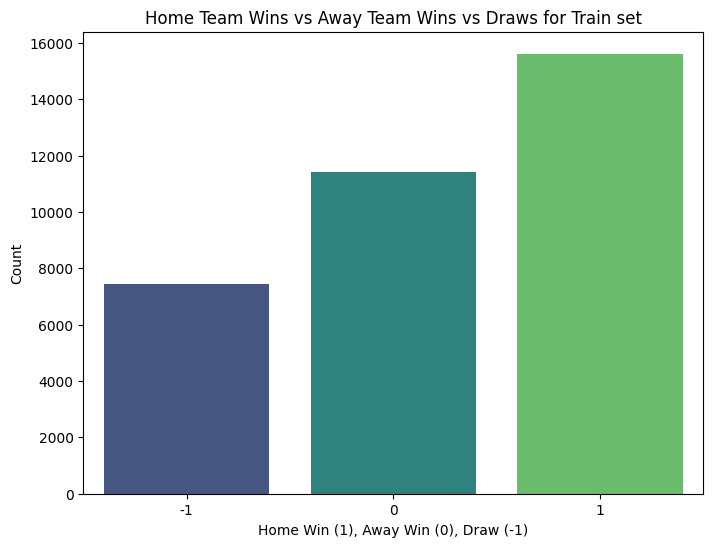

/tmp/ipykernel_180/1766595263.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=win_counts.index, y=win_counts.values, palette='viridis')


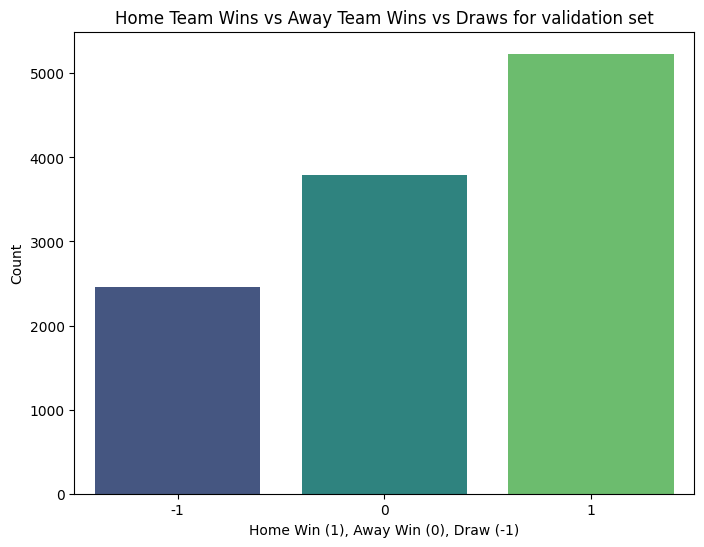

/tmp/ipykernel_180/1766595263.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=win_counts.index, y=win_counts.values, palette='viridis')


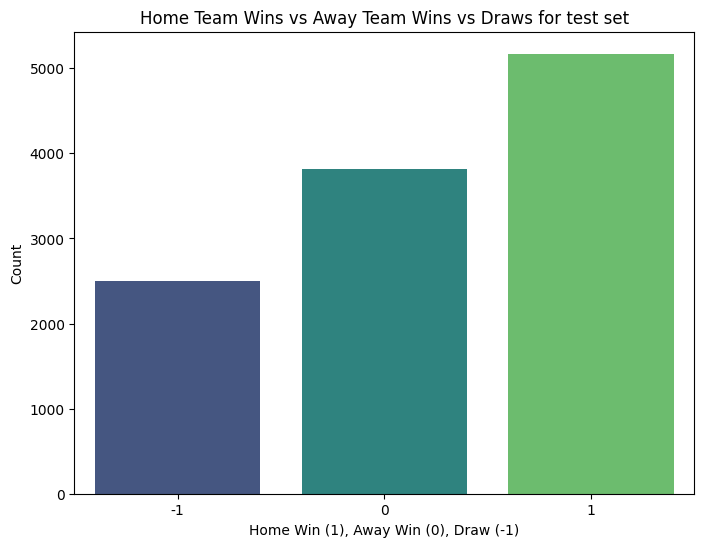

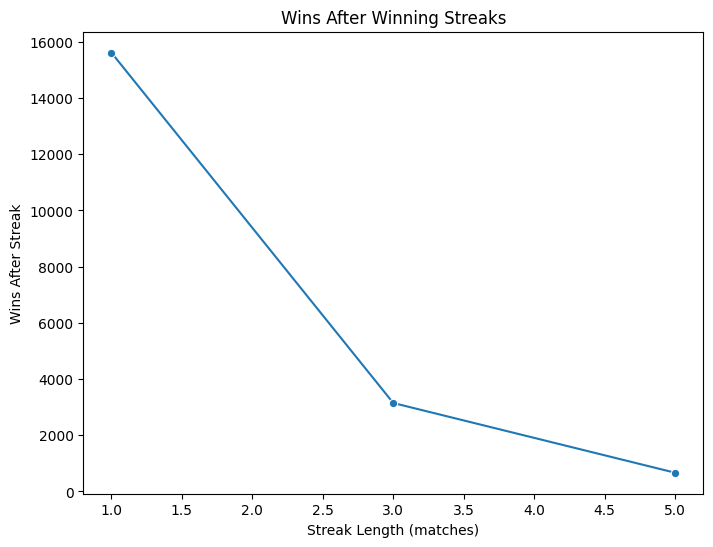

/tmp/ipykernel_180/1766595263.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Manager', y='Win Score', data=top_10_managers_df, palette='viridis')


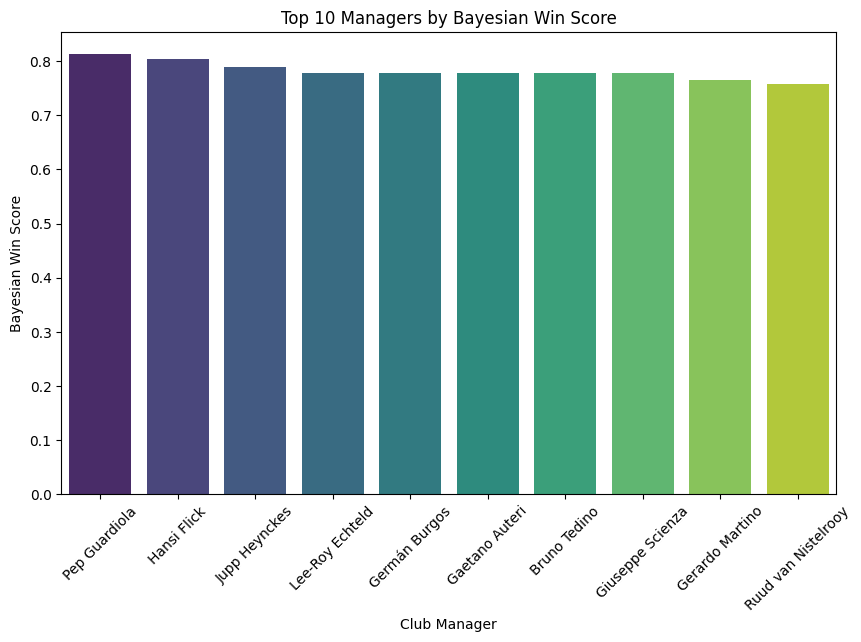

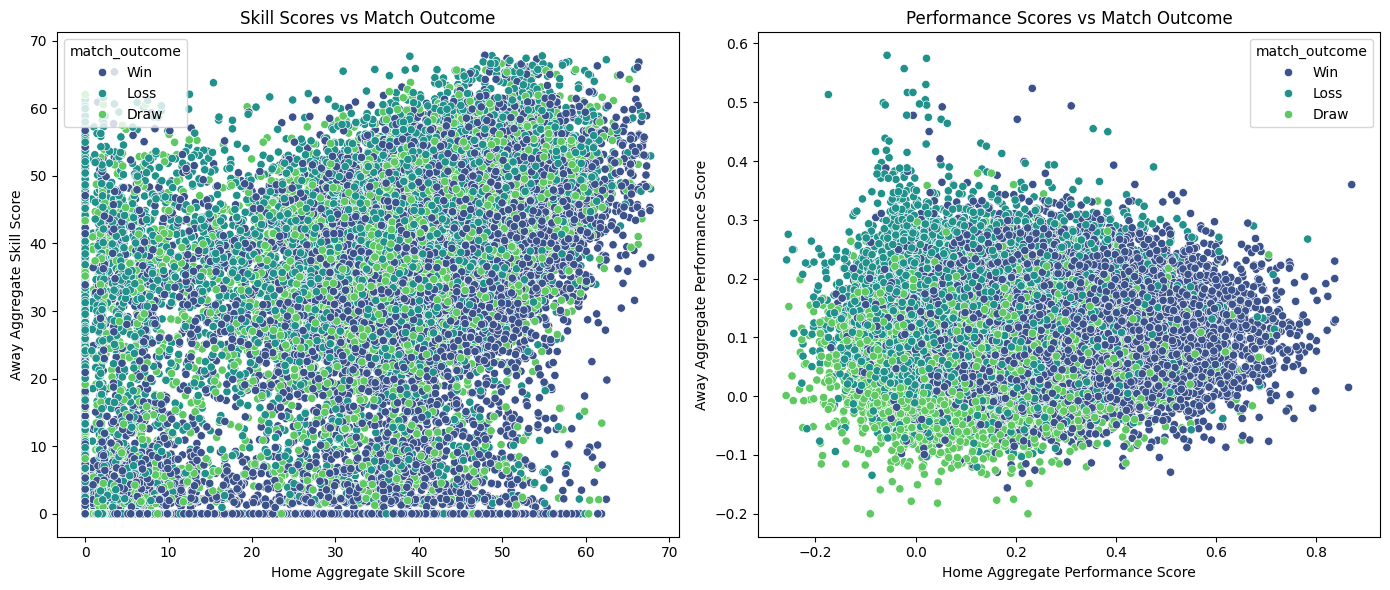

In [39]:
# 1. Instances that home team won vs. away team won vs. draw
win_counts = train_data['home_win'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=win_counts.index, y=win_counts.values, palette='viridis')
plt.title('Home Team Wins vs Away Team Wins vs Draws for Train set')
plt.xlabel('Home Win (1), Away Win (0), Draw (-1)')
plt.ylabel('Count')
plt.show()

win_counts = validation_data['home_win'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=win_counts.index, y=win_counts.values, palette='viridis')
plt.title('Home Team Wins vs Away Team Wins vs Draws for validation set')
plt.xlabel('Home Win (1), Away Win (0), Draw (-1)')
plt.ylabel('Count')
plt.show()

win_counts = test_data['home_win'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=win_counts.index, y=win_counts.values, palette='viridis')
plt.title('Home Team Wins vs Away Team Wins vs Draws for test set')
plt.xlabel('Home Win (1), Away Win (0), Draw (-1)')
plt.ylabel('Count')
plt.show()

# 2. Instances a team won given it won the last match, last 3 matches, and last 5 matches
def calculate_wins_after_streak(df, streak_length):
    df['win_streak'] = df['home_win'].rolling(streak_length).apply(lambda x: all(x == 1), raw=True)
    wins_after_streak = df[(df['win_streak'] == 1) & (df['home_win'] == 1)].shape[0]
    return wins_after_streak

streak_lengths = [1, 3, 5]
wins_after_streaks = [calculate_wins_after_streak(train_data, sl) for sl in streak_lengths]

plt.figure(figsize=(8, 6))
sns.lineplot(x=streak_lengths, y=wins_after_streaks, marker='o')
plt.title('Wins After Winning Streaks')
plt.xlabel('Streak Length (matches)')
plt.ylabel('Wins After Streak')
plt.show()

# 3. Number of wins for a club manager and raw probability
# Plot the win scores for the top 10 managers
plt.figure(figsize=(10, 6))
sns.barplot(x='Manager', y='Win Score', data=top_10_managers_df, palette='viridis')
plt.title('Top 10 Managers by Bayesian Win Score')
plt.xlabel('Club Manager')
plt.ylabel('Bayesian Win Score')
plt.xticks(rotation=45)
plt.show()

# Assuming the data is in train_data DataFrame
# Reclassify match outcomes
train_data['match_outcome'] = train_data['home_win'].apply(lambda x: 'Win' if x == 1 else ('Loss' if x == 0 else 'Draw'))

# 1. Scatter Plots for Skill Scores vs. Match Outcome
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='home_aggregate_skill_score', y='away_aggregate_skill_score', hue='match_outcome', data=train_data, palette='viridis')
plt.title('Skill Scores vs Match Outcome')
plt.xlabel('Home Aggregate Skill Score')
plt.ylabel('Away Aggregate Skill Score')

plt.subplot(1, 2, 2)
sns.scatterplot(x='home_aggregate_performance', y='away_aggregate_performance', hue='match_outcome', data=train_data, palette='viridis')
plt.title('Performance Scores vs Match Outcome')
plt.xlabel('Home Aggregate Performance Score')
plt.ylabel('Away Aggregate Performance Score')

plt.tight_layout()
plt.show()

# Baseline Model 

In [22]:
columns = ['home_club_id', 'away_club_id', 'home_aggregate_skill_score',
                   'away_aggregate_skill_score', 'home_aggregate_performance', 
                   'away_aggregate_performance', 'home_manager_score', 
                   'away_manager_score', 'home_head_head_prob']
X_train = train_data[columns]
y_train = train_data['home_win']
X_val = validation_data[columns]
y_val = validation_data['home_win']
X_test = test_data[columns]
y_test = test_data['home_win']

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (34463, 9)
Validation data shape: (11488, 9)
Test data shape: (11488, 9)


In [38]:
# Identify the numeric columns for normalization
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
# Normalize the numeric columns
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Define the Logistic Regression model
model = LogisticRegression(multi_class='multinomial', max_iter=1000, solver='lbfgs')

# Define hyperparameter grid for tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print(f"Best parameters: {grid_search.best_params_}")

# Train the model with the best parameters on the training set
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Evaluate the model on the validation set
y_val_pred = best_model.predict(X_val)
y_val_pred_prob = best_model.predict_proba(X_val)

val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
val_roc_auc = roc_auc_score(y_val, y_val_pred_prob, multi_class='ovr')

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")
print(f"Validation ROC AUC Score: {val_roc_auc:.4f}")
print(classification_report(y_val, y_val_pred))

# Evaluate the best model on the test set
y_test_pred = best_model.predict(X_test)
y_test_pred_prob = best_model.predict_proba(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test ROC AUC Score: {test_roc_auc:.4f}")
print(classification_report(y_test, y_test_pred))

/tmp/ipykernel_180/1734992820.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
/tmp/ipykernel_180/1734992820.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
/tmp/ipykernel_180/1734992820.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Best parameters: {'C': 0.1}
Validation Accuracy: 0.5776
Validation F1 Score: 0.5636
Validation ROC AUC Score: 0.7351
              precision    recall  f1-score   support

          -1       0.48      0.28      0.35      2459
           0       0.55      0.56      0.56      3796
           1       0.62      0.73      0.67      5233

    accuracy                           0.58     11488
   macro avg       0.55      0.52      0.53     11488
weighted avg       0.57      0.58      0.56     11488

Test Accuracy: 0.5668
Test F1 Score: 0.5529
Test ROC AUC Score: 0.7296
              precision    recall  f1-score   support

          -1       0.47      0.27      0.34      2505
           0       0.54      0.55      0.55      3812
           1       0.61      0.72      0.66      5171

    accuracy                           0.57     11488
   macro avg       0.54      0.52      0.52     11488
weighted avg       0.55      0.57      0.55     11488

